In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# import torch.multiprocessing as multiprocessing
# import multiprocessing as multiprocessing

# multiprocessing.set_start_method('spawn')

In [3]:
# import resource

# rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
# resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

In [4]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [ ]:
import os, random, collections
import pandas as pd
import cv2
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [ ]:
from collections import defaultdict

In [ ]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')


from zoo.unet import DPNUnet
from zoo.dpn import dpn92
from utils.classification_dataset import ISIC_Dataset, EqualizedSampler, ValSampler, MEAN, STD

from utils.losses import BCEDiceJaccardLoss
from utils.metrics import calc_iou
from utils.hard_negative import HardNegativeMiner

from utils.attributes_augmentations import Augmentation
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
# GPU_IDX = 1
EPS = 1e-5
LR_GAMMA = .95
SEED = 42
EPOCHS_NB = 50
PATHS = {
    'DATA': '../data/ISIC2018_Task3_Training_Input/',
    'CSV': '../data/ISIC2018_Task3_Training_GroundTruth/\
ISIC2018_Task3_Training_GroundTruth.csv'

}

In [ ]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[(dataset.keys[idx], 0)]
    pred_mask = F.sigmoid(
        model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]
    ).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    channel = np.unique(np.where(true_mask)[-1]).min()
    pred_mask = pred_mask.T[..., channel]
    true_mask = true_mask[..., channel]
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask)
        ax[2].imshow(pred_mask)
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [11]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [12]:
def freeze(model, freeze=True):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad != freeze
    return model

def unfreeze_bn(model):
    if isinstance(model, nn.BatchNorm2d):
        for param in model.parameters():
            param.requires_grad = True

    model = list(model.children())
    if len(model):
        for child in model:
            unfreeze_bn(child)
    return None

def unfreeze_clf(model):
    for child in model.children():
        if isinstance(child, nn.Conv2d):
            clf = child
    for param in clf.parameters():
        param.requires_grad = True

    return model


In [13]:
def get_datasets(data_dir, fold, df, aug_strength=1.):
    train_dataset = ISIC_Dataset(data_dir, df, seed=SEED,
                                 augmentator=Augmentation, aug_params={
                                     'side': 448, 
                                     'strength': aug_strength
                                 }, is_test=True, part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, df, seed=SEED,
                               augmentator=Augmentation, aug_params={
                                   'side': 448
                               }, 
                               is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_datagens(train_dataset, val_dataset, df, train_batch_size=28):
    train_datagen = torch.utils.data.DataLoader(train_dataset, 
                                                sampler=EqualizedSampler(train_dataset, df), 
                                                batch_size=train_batch_size, 
                                                num_workers=0)
    val_datagen = torch.utils.data.DataLoader(val_dataset,
                                              sampler=ValSampler(val_dataset, df), 
                                              batch_size=1,
                                              num_workers=0)
    return train_datagen, val_datagen


def get_model(checkpoint=None, map_location=None, devices=None):
    model = dpn92(3, 7)
    model.cuda();

    if checkpoint is not None:
        sd = torch.load(checkpoint, map_location).state_dict()
        msd = model.state_dict()
        sd = {k: v for k, v in sd.items() if k in msd}
        msd.update(sd)
        model.load_state_dict(msd)

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model

In [14]:
def make_step(model, data, loss, opt=None, training=True):
    images = Variable(data['images']).cuda()
    masks = Variable(data['class']).cuda()

    predictions = model(images)
    l = loss(predictions, masks)
    pred = F.softmax(
        predictions,
        dim=1
    ).data.cpu().numpy()

    if training:
        l.backward()
        opt.step()

    return {
        'loss': l, 
        'preds': pred,
        'trues': data['class']
    }

In [15]:
def train_on_epoch(model, loss, opt, datagen, epsilon=1e-5, hard_negative_miner=None):
    model.train()
    meters = list()
    preds = list()

    for images_, class_ in tqdm(datagen):
        opt.zero_grad()
        data = {
            'images': images_, 
            'class': class_[:, 0]
        }
        meters.append(make_step(model, data, loss, opt, training=True))
        preds.append({key: meters[-1][key] for key in ['preds', 'trues']})

        if hard_negative_miner is not None:
            hard_negative_miner.update_cache(meters[-1], data)
            if hard_negative_miner.need_iter():
                make_step(model, hard_negative_miner.get_cache(), loss, opt, training=True)
                hard_negative_miner.invalidate_cache()

    losses = sum([meter['loss'] for meter in meters])
    losses = losses.data.cpu().numpy() / len(meters)
#     ious = sum([meter['preds'] for meter in meters]) / sum([meter['union'] for meter in meters])
    
    opt.zero_grad()

    return losses, preds

In [16]:
def validate(model, loss, datagen):
    model.eval()
    preds, losses = list(), list()

    with torch.no_grad():
        for images_, class_ in tqdm(datagen):
            meter = make_step(model, {
                'images': images_, 
                'class': class_[:, 0]
            }, loss, training=False)
            preds.append({key: meter[key] for key in ['preds', 'trues']})
            losses.append(meter['loss'].data.cpu().numpy())

    return losses, preds

In [17]:
def visualize(train_losses, val_losses):
    clear_output(wait=True)
    _, axes = plt.subplots(ncols=2, figsize=(15, 6))

    axes[0].plot(train_losses, label='Train')
#     for i, key in enumerate(['segm']):
#             axes[0].plot([v[key] for v in train_iou], label='Train {}'.format(key), alpha=0.7, color='C{}'.format(i * 2))    
#             axes[0].plot([v[key] for v in val_iou], label='Val {}'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

    axes[0].plot(val_losses, label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

#     key = 'full_attr'
#     nb_classes = len(val_iou[0][key])

#     for i in range(nb_classes):
#         axes[1].plot([v[key][i] for v in train_iou], label='Train {}'.format(attributes[i].split('_')[-2]), alpha=0.7)
    
#     for i in range(nb_classes):
#         axes[1].plot([v[key][i] for v in val_iou], label='Val {}'.format(attributes[i].split('_')[-2]), alpha=0.7)

#     axes[1].set_title('IoU')
#     axes[1].legend()
#     axes[1].grid()

    plt.show()

In [18]:
def dump_intermediates(model, val_dataset, fold, epoch_i):
    model.eval()
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 0, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=32, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 32, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=True, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 17, epoch_i)
    )

In [19]:
def orchestrate(data_dir, fold, df, model=None, losses=None, model_pth=None, 
                epoch_nb=1, map_location=None, clf_freeze_iter=0, postfix='',
                lr=1e-4, aug_strength=1., hard_negative_miner=None,
                checkpoints_pth='checkpoints', verbose=False, devices=None, 
                train_batch_size=8, lr_scheduler=None, strength_decay=1., 
                min_strength=.7, converge_appearence=.1):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}' + postfix)
    if model is None:
        model = get_model(model_pth, map_location, devices)
    if model_pth is not None:
        pl = path.format(fold, 'loss')
        if os.path.isfile(pl):
            losses = pickle.load(open(pl, 'rb'))
    if losses is None:
        losses = defaultdict(list)
    last_epoch = len(losses)

    loss = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    for group in opt.param_groups:
        group.setdefault('initial_lr', group['lr'])

    if lr_scheduler is not None:
        lr_scheduler = lr_scheduler(opt, LR_GAMMA, last_epoch)

    train_losses, val_losses = [], []
    train_iou, val_iou = [], []
    
    train_dataset, val_dataset = get_datasets(data_dir, fold, df=df, aug_strength=aug_strength * strength_decay ** last_epoch)
    train_datagen, val_datagen = get_datagens(train_dataset, val_dataset, df=df, train_batch_size=train_batch_size)

    try:
        for epoch_i in range(last_epoch, epoch_nb):
            model = freeze(model, freeze=(epoch_i >= clf_freeze_iter))
            unfreeze_bn(model)
            model = unfreeze_clf(model)

            if lr_scheduler is not None:
                lr_scheduler.step()

            l, iou = train_on_epoch(model, loss, opt, train_datagen, hard_negative_miner=hard_negative_miner)
            losses['train_losses'].append(l)

            l, ious = validate(model, loss, val_datagen)
            losses['val_losses'].append(np.mean(l))

            if verbose:
                visualize(
                    losses['train_losses'], 
                    losses['val_losses'], 
#                     losses['train_iou'], 
#                     losses['val_iou']
                )

            if train_dataset.aug_params['strength'] > min_strength:
                train_dataset.aug_strength_decay(strength_decay)

            if (checkpoints_pth is not None) and ((epoch_i) % 1 == 0):
                torch.save(model, path.format(fold, epoch_i))
                pickle.dump(losses, open(path.format(fold, 'loss'), 'wb'))
                print(path)

            train_dataset.converge_appearence(decay=converge_appearence)

    except KeyboardInterrupt:
        return model, losses

    return model, losses

In [20]:
import pandas as pd

df = pd.read_csv(PATHS['CSV'])

In [21]:
cv2.setNumThreads(0)

In [22]:
EPOCHS_NB = 20

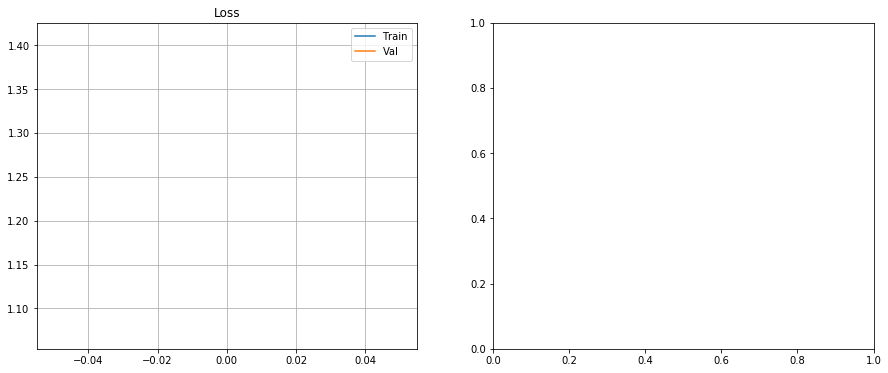

  0%|          | 0/939 [00:00<?, ?it/s]

classification_checkpoints/dpn92/fold_{}_checkpoint.epoch_{}_pure
appearence recomputed
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


  6%|▋         | 60/939 [00:46<11:16,  1.30it/s]

In [ ]:
fold = 0
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    df=df,
    postfix='_pure',
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='classification_checkpoints/dpn92/', 
    lr=1e-4,
    aug_strength=1.8,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=1.,
    verbose=True,
    train_batch_size=8,
    clf_freeze_iter=0,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=None
)

In [ ]:
fold = 1
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    df=df,
    postfix='_pure',
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='classification_checkpoints/dpn92/', 
    lr=1e-4,
    aug_strength=1.8,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=1.,
    verbose=True,
    train_batch_size=8,
    clf_freeze_iter=0,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=None
)

In [ ]:
fold = 2
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    df=df,
    postfix='_pure',
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='classification_checkpoints/dpn92/', 
    lr=1e-4,
    aug_strength=1.8,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=1.,
    verbose=True,
    train_batch_size=8,
    clf_freeze_iter=0,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=None
)

In [ ]:
fold = 3
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    df=df,
    postfix='_pure',
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='classification_checkpoints/dpn92/', 
    lr=1e-4,
    aug_strength=1.8,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=1.,
    verbose=True,
    train_batch_size=8,
    clf_freeze_iter=0,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=None
)